# Deep Learning Model 

In [1]:
# #!pip3 install opencv-python
# !pip install tensorflow
# !pip install sklearn
# !pip install seaborn
# !pip install matplotlib

In [13]:
# Libraries

import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
import random
import pickle


#from PIL import Image
#!pip install mat73
import mat73
import helper

#import cv2

import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.layers import Dense, Flatten, Concatenate
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import seaborn as sns

import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import EarlyStopping

### Parameters

In [2]:
resize = 0.2

## Image loading and preprocessing

In [3]:
### Load each file independently (to avoid memory overflows) and retriev PID
patient_ids_dict = dict()
label_ids_dict = dict()
shape_x_dict = dict()
shape_y_dict = dict()
image_dict = dict()

for file_number in range(1,3047):
    file = f'../data/brain-tumor-data-public/{file_number}.mat'
    data_dict = mat73.loadmat(file)
    patient_ids_dict[file_number] = data_dict['cjdata']['PID']
    label_ids_dict[file_number] = int(data_dict['cjdata']['label'])
    shape_x_dict[file_number] = data_dict['cjdata']['image'].shape[0]
    shape_y_dict[file_number] = data_dict['cjdata']['image'].shape[1]
    image_dict[file_number] = data_dict['cjdata']['image']

In [4]:
patient_ids = pd.Series(patient_ids_dict)
label_ids = pd.Series(label_ids_dict)
shape_x = pd.Series(shape_x_dict)
shape_y = pd.Series(shape_y_dict)
image = pd.Series(image_dict)

patients = pd.DataFrame({'pid':patient_ids, 'label':label_ids,
                         'x':shape_x, 'y':shape_y, 'image':image}, index=range(1, 3047))

In [5]:
patients['image'] = patients['image'].apply(lambda x : helper.imx_preproc(x, zero_up_to_one=True, resize=resize))
patients['image'] = patients['image'].apply(lambda x : x.astype('float32'))

## Train and Validation Sets

In [6]:
random.seed(1234)

val_size = 0.2
test_size = 0.2
# Training set has 2436 images test set has 610 images 
train_set, test_set = train_test_split(patients, stratify=patients['label'], test_size=test_size)
# Training set has 1948 images, validation set has 488 images
train_set, val_set = train_test_split(train_set, stratify=train_set['label'], test_size=val_size)

n_total_train = train_set.shape[0]

train_set_x = np.stack(train_set['image'].values)
train_set_y = np.array(train_set['label'])

val_set_x = np.stack(val_set['image'].values)
val_set_y = np.array(val_set['label'])

test_set_x = np.stack(test_set['image'].values)
test_set_y = np.array(test_set['label'])

We also add a 3 color channel representation of the image (by repeating the one channel we had 3 times). We do this to be able to use pretrained CNN that require us to provide inputs with that 3rd dimension. 

This is not the only way to proceed, but it should be good enough for our purposes and given that we can afford storing the data (because it is small in quantity and in image size).

https://towardsdatascience.com/transfer-learning-on-greyscale-images-how-to-fine-tune-pretrained-models-on-black-and-white-9a5150755c7a

In [7]:
train_set['image_3_channels'] = train_set['image'].apply(lambda x: np.expand_dims(x, axis = -1))
train_set['image_3_channels'] = train_set['image_3_channels'].apply(lambda x : x.repeat(3, axis = -1))

val_set['image_3_channels'] = val_set['image'].apply(lambda x: np.expand_dims(x, axis = -1))
val_set['image_3_channels'] = val_set['image_3_channels'].apply(lambda x : x.repeat(3, axis = -1))

#The following 2 lines result in warnings, but they work fine
test_set['image_3_channels'] = test_set['image'].apply(lambda x: np.expand_dims(x, axis = -1))
test_set['image_3_channels'] = test_set['image_3_channels'].apply(lambda x : x.repeat(3, axis = -1))

train_set_x_3_channels = np.stack(train_set['image_3_channels'].values)
val_set_x_3_channels = np.stack(val_set['image_3_channels'].values)
test_set_x_3_channels = np.stack(test_set['image_3_channels'].values)

/var/folders/4s/2nft871j0wd73bwxhvqv7zj40000gn/T/ipykernel_28570/65434859.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['image_3_channels'] = test_set['image'].apply(lambda x: np.expand_dims(x, axis = -1))
/var/folders/4s/2nft871j0wd73bwxhvqv7zj40000gn/T/ipykernel_28570/65434859.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['image_3_channels'] = test_set['image_3_channels'].apply(lambda x : x.repeat(3, axis = -1))


Applying one hot encoding to target variable y 

In [8]:
new_train_set_y = tf.one_hot(train_set_y, depth = 4)
new_train_set_y = np.array(new_train_set_y)[:,1:]

2022-05-11 21:37:04.130130: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
new_val_set_y = tf.one_hot(val_set_y, depth = 4)
new_val_set_y = np.array(new_val_set_y)[:,1:]

## CNN Implementation

In [10]:
batch_size = 64
IMG_H = int(round(512 * resize, 0))
IMG_W = int(round(512 * resize, 0))

optimizer = 'adam'

#### Build custom CNN

In [261]:
CNN = Sequential([
    InputLayer(input_shape=(IMG_H, IMG_W, 1)),
#     InputLayer(input_shape=(IMG_H, IMG_W, 3)), # For 3 channels
    
    Conv2D(64, 9, activation='relu',strides=(5, 5)),
    MaxPool2D(),

    #Conv2D(64, 9, activation='relu'),
    #MaxPool2D(),

    #Conv2D(64, 5, activation='relu'),
    #MaxPool2D(),

    #Conv2D(64, 3, activation='relu'),
    #MaxPool2D(),

    Flatten(),
    Dense(512, activation='relu'),
#     Dense(1, activation='sigmoid')
    Dense(3, activation='softmax')
])

CNN.summary()

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_166 (Conv2D)         (None, 19, 19, 64)        5248      
                                                                 
 max_pooling2d_166 (MaxPooli  (None, 9, 9, 64)         0         
 ng2D)                                                           
                                                                 
 flatten_56 (Flatten)        (None, 5184)              0         
                                                                 
 dense_112 (Dense)           (None, 512)               2654720   
                                                                 
 dense_113 (Dense)           (None, 3)                 1539      
                                                                 
Total params: 2,661,507
Trainable params: 2,661,507
Non-trainable params: 0
___________________________________________

In [262]:
# Compile: Define training parameters
CNN.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
EPOCHS = 50
BATCHES = n_total_train//batch_size

### Following line overflows memory
fitted_model = CNN.fit(train_set_x, new_train_set_y, steps_per_epoch=BATCHES,
                       epochs=EPOCHS, validation_data=(val_set_x, new_val_set_y),
                      callbacks=[EarlyStopping(monitor='val_accuracy', patience=5)])

Epoch 1/50
30/30 [==============================] - 1s 32ms/step - loss: 0.7916 - accuracy: 0.6453 - val_loss: 0.6302 - val_accuracy: 0.6988
Epoch 2/50
30/30 [==============================] - 1s 28ms/step - loss: 0.5516 - accuracy: 0.7495 - val_loss: 0.5393 - val_accuracy: 0.7520
Epoch 3/50
30/30 [==============================] - 1s 27ms/step - loss: 0.4679 - accuracy: 0.7952 - val_loss: 0.5423 - val_accuracy: 0.7787
Epoch 4/50
30/30 [==============================] - 1s 27ms/step - loss: 0.3712 - accuracy: 0.8393 - val_loss: 0.3885 - val_accuracy: 0.8176
Epoch 5/50
30/30 [==============================] - 1s 28ms/step - loss: 0.2903 - accuracy: 0.8778 - val_loss: 0.3594 - val_accuracy: 0.8484
Epoch 6/50
30/30 [==============================] - 1s 29ms/step - loss: 0.2244 - accuracy: 0.9209 - val_loss: 0.3012 - val_accuracy: 0.8689
Epoch 7/50
30/30 [==============================] - 1s 28ms/step - loss: 0.1872 - accuracy: 0.9307 - val_loss: 0.3074 - val_accuracy: 0.8648
Epoch 8/50
30

#### Predefined Arquitectures (with or without Pretrained Weights)

In [118]:
# ############### For 3 channels ###############

# ### Preload the VGG16 architecture with Imagenet Weights
# ### (use this with the "3 channels" cells)
# IMG_SHAPE = (IMG_W, IMG_H, 3)
# CNN = tf.keras.applications.VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

# # Freeze all pre-trained kernels (False), or allow training (True)
# CNN.trainable = False

# # Use pre-trained model as part of a full model - notice the number of trainable parameters
# CNN = Sequential([
#   CNN,
#   Flatten(),
#   Dense(256, activation='relu'),
#   Dense(3, activation='softmax')
# ])

# CNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 4608)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               1179904   
                                                                 
 dense_5 (Dense)             (None, 3)                 771       
                                                                 
Total params: 15,895,363
Trainable params: 1,180,675
Non-trainable params: 14,714,688
_________________________________________________________________


In [119]:
# ############### For 3 channels ###############

# # Compile: Define training parameters
# CNN.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# # Train model
# EPOCHS = 10
# BATCHES = n_total_train//batch_size

# ### Following line overflows memory
# fitted_model = CNN.fit(train_set_x_3_channels, new_train_set_y, steps_per_epoch=BATCHES,
#                        epochs=EPOCHS, validation_data=(val_set_x_3_channels, new_val_set_y))

Epoch 1/10
30/30 [==============================] - 47s 2s/step - loss: 0.8571 - accuracy: 0.6679 - val_loss: 0.3898 - val_accuracy: 0.8340
Epoch 2/10
30/30 [==============================] - 62s 2s/step - loss: 0.3741 - accuracy: 0.8368 - val_loss: 0.3716 - val_accuracy: 0.8361
Epoch 3/10
30/30 [==============================] - 61s 2s/step - loss: 0.3539 - accuracy: 0.8455 - val_loss: 0.3485 - val_accuracy: 0.8668
Epoch 4/10
30/30 [==============================] - 63s 2s/step - loss: 0.3014 - accuracy: 0.8629 - val_loss: 0.3053 - val_accuracy: 0.8730
Epoch 5/10
30/30 [==============================] - 63s 2s/step - loss: 0.2445 - accuracy: 0.9014 - val_loss: 0.2674 - val_accuracy: 0.8770
Epoch 6/10
30/30 [==============================] - 64s 2s/step - loss: 0.2172 - accuracy: 0.9194 - val_loss: 0.2924 - val_accuracy: 0.8811
Epoch 7/10
30/30 [==============================] - 63s 2s/step - loss: 0.1919 - accuracy: 0.9266 - val_loss: 0.3030 - val_accuracy: 0.8893
Epoch 8/10
30/30 [==

### Results

In [263]:
model_id = 'ker_9_stride_5'

#### Summary

In [264]:
with open(f'../results/resize_{resize}/{model_id}_summary.txt', 'w') as f:

    CNN.summary(print_fn=lambda x: f.write(x + '\n'))
    f.close()

#### Hyperparameters

In [265]:
with open(f"../results/resize_{resize}/{model_id}_extended_summary.txt","w") as f:
    aux = CNN.get_config()
    aux['optimizer'] = optimizer
    aux['epoch'] = EPOCHS
    aux['batches'] = BATCHES
    f.write(str(aux))
    f.close()

#### Epoch convergence

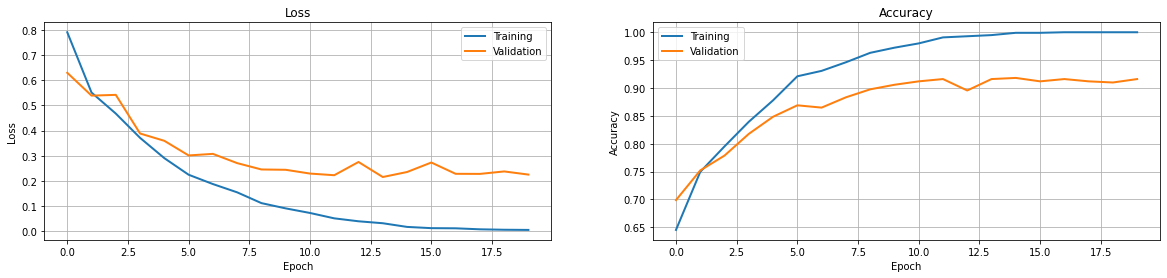

In [266]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(CNN.history.history['loss'], label='Training', linewidth=2)
plt.plot(CNN.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(CNN.history.history['accuracy'], label='Training', linewidth=2)
plt.plot(CNN.history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.savefig(f'../results/resize_{resize}/{model_id}_epochs.png', bbox_inches = 'tight')
plt.show()

#### Confusion Matrix

In [267]:
predictions = CNN.predict(test_set_x)  #por qué no se hace el OHE?
predictions = predictions.argmax(1) + 1

cm = confusion_matrix(test_set_y, predictions)

In [195]:
# ############### For 3 channels ###############
# predictions = CNN.predict(test_set_x_3_channels)  #por qué no se hace el OHE?
# predictions = predictions.argmax(1) + 1

# cm = confusion_matrix(test_set_y, predictions)

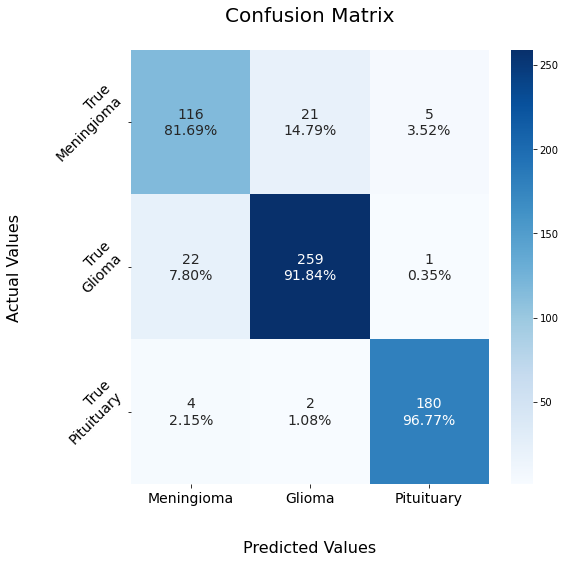

In [268]:
fig, ax = plt.subplots(figsize = (8,8))

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     ((cm.transpose()/cm.sum(1)).transpose()).flatten()]

#group_percentages = ["{0:.2%}".format(value) for value in
#                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(3,3)

ax = sns.heatmap(cm,
                 annot=labels, 
                 fmt='',
                 cmap='Blues',
                 annot_kws = {'fontsize':14})

ax.set_title('Confusion Matrix\n', fontsize = 20);
ax.set_xlabel('\nPredicted Values', labelpad = 18, fontsize = 16)
ax.set_ylabel('Actual Values', labelpad = 20, fontsize = 16);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Meningioma','Glioma', 'Pituituary'], fontsize = 14)
ax.yaxis.set_ticklabels(['True\nMeningioma','True\nGlioma', 'True\nPituituary'], fontsize = 14, rotation = 45)

## Display the visualization of the Confusion Matrix.
plt.savefig(f'../results/resize_{resize}/{model_id}_confusion_matrix.png', bbox_inches = 'tight')
plt.show()

In [269]:
f1 = f1_score(test_set_y, predictions, average='weighted')
acc = accuracy_score(test_set_y, predictions)

In [270]:
with open(f'../results/resize_{resize}/{model_id}_performance.txt', 'w') as f:

    performance = {'F1 score': round(f1,4), 'Accuracy': round(acc,4)}
    
    f.write(str(performance))
    f.close()

#### Pickle file

In [271]:
CNN.save(f'../results/resize_{resize}/{model_id}_model.h5')